In [1]:
# Standaard libaries voor visualiseren en dataverwerking
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libaries gebruikt bij de seizoens analyse
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import DeterministicProcess

# Libaries gebruikt bij functies rondom modelleren
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# Libaries van de modellen
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor

In [2]:
# Inladen van de test dataset
data_test = pd.read_csv('test.csv', sep = ',')

# Inladen van de train dataset
data_train = pd.read_csv('train.csv', sep = ',')

In [3]:
# Aanmaken van nieuw DataFrame
df_time = data_train[['date_hour', 'cnt']].copy()
df_time['date_hour'] = pd.to_datetime(df_time['date_hour'])
df_time = df_time.set_index('date_hour')
df_time.head()

,cnt
date_hour,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


In [4]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Toegevoegd op basis van eigen ingeving
    df['Jaar'] = df[f'{dt_kol}'].dt.year.astype(int)
    df['Maand'] = df[f'{dt_kol}'].dt.month.astype(int)
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week.astype(int)
    df['Uur'] = df[f'{dt_kol}'].dt.hour.astype(int)

    # Toegevoegd na aanleiding FFT
    df['is_weekend'] = (df[f'{dt_kol}'].dt.dayofweek >= 5).astype(int)
    df['day_of_week'] = df[f'{dt_kol}'].dt.weekday.astype(int)

    return df

In [5]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Uur,is_weekend,day_of_week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,0,1,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,2,1,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,3,1,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,4,1,5


In [6]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [7]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

def feature_scan(model):
    """
    Een functie die een grafie met de feature importances kan maken.
    Dit werkt in ieder geval voor de RF en XGB modellen.

    Parameters:
    ----------
    model : ML-model
    Het model waarvan je de feature importances wilt tonen.

    Returns:
    ----------
    None
    Laat een grafiek zien met daarin de invloed van alle features.
    """
    # Aanmaken en sorteren invloed kolommen
    invloed = pd.Series(model.feature_importances_, index=X.columns)
    invloed = invloed.sort_values(ascending=True)

    # Plotten grafiek met invloed
    invloed.plot(kind='barh', figsize=(10, 6))
    plt.ylabel('Features')
    plt.xlabel('Invloed')
    plt.show()
    

In [8]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=456, random_state=SEED)

# Aanmaken van de folds
cv = TimeSeriesSplit(n_splits=5, test_size=456)

# Sarimax

Sarimax is een tijdserie model en de afkorting staat voor Seasonal AutoRegresive Integrated Moving Avarege eXogenous.

Als eerst gaan we een Dickey-Fuller test uitvoeren. Deze bepaalt of een dataset stationair is of niet. De data is stationair als de waarde van p kleiner of gelijk is aan het significantie level. Als de p-waarde groter is, is de data niet stationair

In [9]:
from statsmodels.tsa.stattools import adfuller
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['cnt'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.625165e+00
p-value                        5.901289e-09
#Lags Used                     4.300000e+01
Number of Observations Used    1.659300e+04
Critical Value (1%)           -3.430744e+00
Critical Value (5%)           -2.861714e+00
Critical Value (10%)          -2.566863e+00
dtype: float64


Onze data is stationair want p-value is 5,901289 x 10^-9 dit is veel kleiner dan een significantie level van 0.05 dus is de data stationair

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


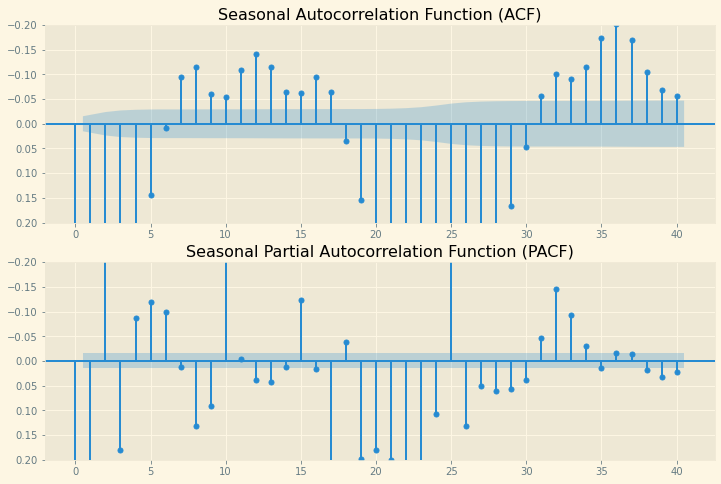

In [181]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Seasonal ACF plot
plot_acf(df_time['cnt'], lags=40, ax=ax1)
ax1.set_title('Seasonal Autocorrelation Function (ACF)')
ax1.set_ylim(0.2, -0.2)

# Seasonal PACF plot
plot_pacf(df_time['cnt'], lags=40, ax=ax2)
ax2.set_title('Seasonal Partial Autocorrelation Function (PACF)')
ax2.set_ylim(0.2, -0.2)

plt.show()

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [126]:
split_point = int(len(df) * 0.8)
train, test = df[0:split_point], df[split_point:]


In [179]:
model = SARIMAX(train['cnt'], order=(5, 1, 6), seasonal_order=(0, 1, 1, 24))
model = model.fit(disp=True)

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


De order hebben we gekozen door veel te proberen en uiteindelijke de beste te kiezen. Hieronder laten we zien welke order en seasonal_orden we hebben gebruikt.

- #order=(5, 1, 6), seasonal_order=(0, 0, 0, 24)
- #order=(1, 0, 1), seasonal_order=(0, 0, 0, 24)
- #order=(3, 1, 0), seasonal_order=(0, 0, 0, 24)
- #order=(5, 1, 6), seasonal_order=(1, 1, 0, 24)
- #order=(5, 1, 6), seasonal_order=(0, 1, 0, 24)
- #order=(5, 1, 6), seasonal_order=(0, 1, 1, 24)
- #order=(5, 1, 6), seasonal_order=(1, 1, 1, 24)

We hebben voor een p van 5 gekozen want als je bij de ACF de bolletjes telt tot het eerste bolletje dat in de betrouwbaarheids ding (?) zit, zijn dat er 5. De q van 6 hebben we op dezelfde manier geteld maar dan bij de PACF plot.

Voor seasonal error wisten we dat de S 24 is want dat is onze seasonal period.

En voor de PDQ hebben we veel geprobeerd en uiteindelijk zijn wij op 0,1,1 gekomen.


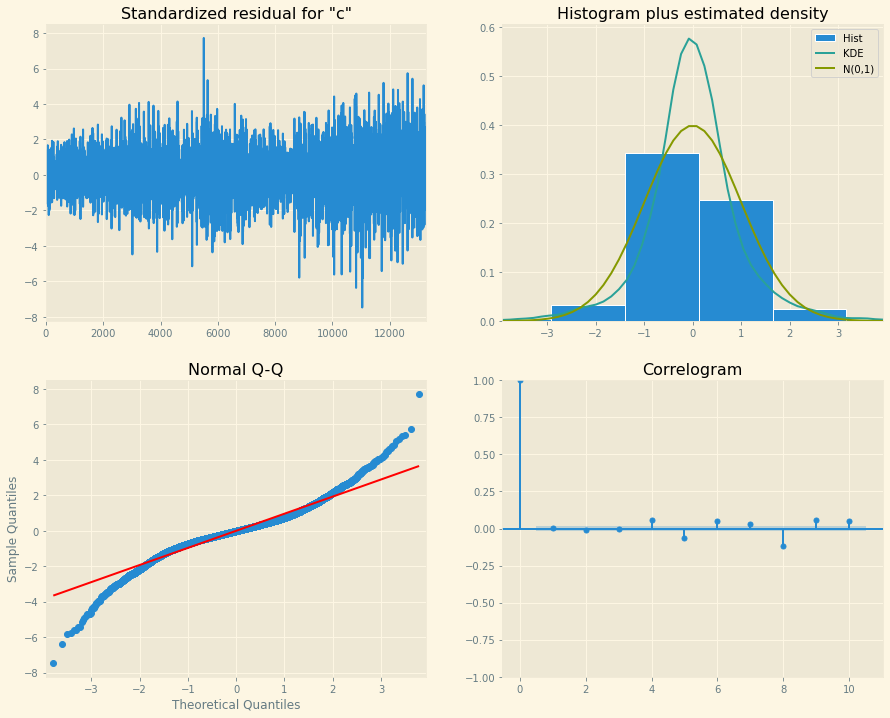

In [183]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

#uitleg hier over

In [173]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have a test dataset called 'test' with the corresponding 'cnt' values
test['predicted'] = model.predict(start=test.index[0], end=test.index[-1], dynamic=True)

# Calculate the squared differences between predicted and actual values
squared_diff = (test['cnt'] - test['predicted'])**2

# Calculate the mean squared error
mse = np.mean(squared_diff)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 195.19688200939135


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_12244\807267484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted'] = model.predict(start=test.index[0], end=test.index[-1], dynamic=True)


In [89]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cnt   No. Observations:                16527
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -98234.015
Date:                Thu, 23 Nov 2023   AIC                         196476.029
Time:                        13:42:53   BIC                         196506.880
Sample:                             0   HQIC                        196486.217
                              - 16527                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.006     69.881      0.000       0.377       0.399
ar.L2         -0.3011      0.008    -37.746      0.000      -0.317      -0.285
ar.L3         -0.0197      0.010     -1.898      0.058      -0.040       0.001
sigma2      8524.3644     59.849    142.432      0.000    8407.063    8641.666
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13753.53
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

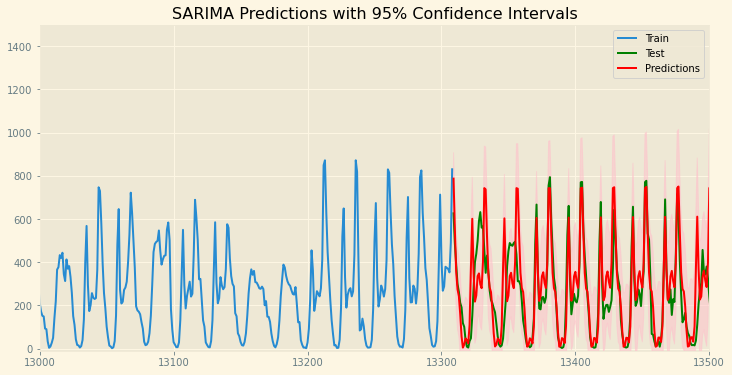

In [163]:
forecast = model.get_forecast(steps=len(test))
predictions = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['cnt'], label='Train')
plt.plot(test.index, test['cnt'], label='Test', color = 'g')
plt.plot(predictions.index, predictions, label='Predictions', color='r')

# Fill area between confidence intervals
plt.fill_between(predictions.index, lower_limits, upper_limits, color='pink', alpha=0.5)

plt.legend()
plt.title('SARIMA Predictions with 95% Confidence Intervals')
plt.ylim(-10, 1500)
plt.xlim(13000, 13500)
plt.show()

#order=(5, 1, 6), seasonal_order=(0, 1, 1, 24)

# Prophet

In [166]:
#!pip install prophet

  Using cached holidays-0.37-py3-none-any.whl (851 kB)


16:08:40 - cmdstanpy - INFO - Chain [1] start processing
16:08:42 - cmdstanpy - INFO - Chain [1] done processing


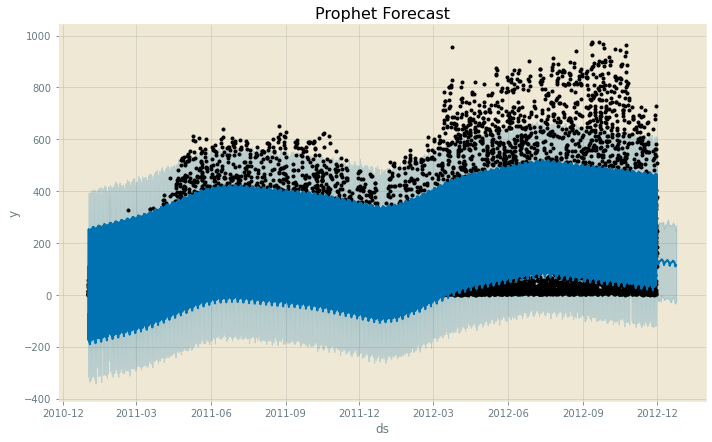

In [176]:
from prophet import Prophet

your_dataframe = df.rename(columns={'date_hour': 'ds', 'cnt': 'y'})

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(your_dataframe)

# Create a dataframe with future dates for prediction
future = model.make_future_dataframe(periods=24)  # Adjust the number of periods as needed

# Generate forecasts
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()